## Setup

In [1]:
!pip install tenseal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 15.6 MB/s eta 0:00:00


In [12]:
# Mounting Google Drive locally to read datasets - pass if working on local!
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import os
path = "/content/drive/MyDrive/ml4health/" # change this to your local path where you have the datasets!
print(os.listdir(path))

['msk_impact_2017_clinical_data.tsv', 'combined_encoded.csv', 'test_encoded.csv', 'train_encoded.csv', 'combined_or.csv']


In [14]:
import torch
import tenseal as ts
import pandas as pd
import random
from time import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

## Data resampling and scaling

In [15]:
torch.random.manual_seed(73)
random.seed(73)

def split_train_test(x, y, test_ratio=0.3):
    idxs = [i for i in range(len(x))]
    random.Random(73).shuffle(idxs)
    # delimiter between test and train data
    delim = int(len(x) * test_ratio)
    test_idxs, train_idxs = idxs[:delim], idxs[delim:]
    return x[train_idxs], y[train_idxs], x[test_idxs], y[test_idxs]

def cancer_data_resampled(path):
    data = pd.read_csv(f"{path}combined_or.csv")
    grouped = data.groupby("Overall Survival Status")
    data = grouped.apply(lambda x: x.sample(grouped.size().min(), random_state=73).reset_index(drop=True))

    # extract labels
    y = torch.tensor(data["Overall Survival Status"].values).float().unsqueeze(1)
    data = data.drop("Overall Survival Status", axis = 1)

    # standardize data
    scaler = StandardScaler()
    data = scaler.fit_transform(data)

    x = torch.tensor(data).float()
    return split_train_test(x, y)

x_train_resampled, y_train_resampled, x_test_resampled, y_test_resampled = cancer_data_resampled(path)

print("############# Data summary #############")
print(f"x_train has shape: {x_train_resampled.shape}")
print(f"y_train has shape: {y_train_resampled.shape}")
print(f"x_test has shape: {x_test_resampled.shape}")
print(f"y_test has shape: {y_test_resampled.shape}")
print("#######################################")

############# Data summary #############
x_train has shape: torch.Size([4339, 67])
y_train has shape: torch.Size([4339, 1])
x_test has shape: torch.Size([1859, 67])
y_test has shape: torch.Size([1859, 1])
#######################################


## 1-layer-NN LR functions

In [16]:
class LR(torch.nn.Module):

    def __init__(self, n_features):
        super(LR, self).__init__()
        self.lr = torch.nn.Linear(n_features, 1)

    def forward(self, x):
        out = torch.sigmoid(self.lr(x))
        return out

In [17]:
EPOCHS = 10

def train(model, optim, criterion, x, y, epochs=EPOCHS):
    for e in range(1, epochs + 1):
        optim.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optim.step()
    return model

## Plain & encrypted evaluations

In [18]:
class EncryptedLR:

    def __init__(self, torch_lr):
        self.weight = torch_lr.lr.weight.data.tolist()[0]
        self.bias = torch_lr.lr.bias.data.tolist()

    def forward(self, enc_x):
        enc_out = enc_x.dot(self.weight) + self.bias
        return enc_out

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)

    def decrypt(self, context):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()

In [19]:
# parameters
poly_mod_degree = 4096
coeff_mod_bit_sizes = [40, 20, 40]
# create TenSEALContext
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
# scale of ciphertext to use
ctx_eval.global_scale = 2 ** 20
# this key is needed for doing dot-product operations
ctx_eval.generate_galois_keys()

In [20]:
accuracy_list = []
accuracy_list_encrypted = []
f1_list = []
f1_list_encrypted = []
roc_auc_list = []
roc_auc_list_encrypted = []
time_list = []
time_list_encrypted = []

for _ in range(10): # training and HE evaluation 50 times
    n_features = x_train_resampled.shape[1]
    model = LR(n_features)

    optim = torch.optim.SGD(model.parameters(), lr=.5)
    criterion = torch.nn.BCELoss()
    trained_model = train(model, optim, criterion, x_train_resampled, y_train_resampled)

    t_start = time()
    nc_out = trained_model(x_test_resampled)
    t_end = time()
    time_list.append(t_end-t_start)
    nc_out = [1 if p >= 0.5 else 0 for p in nc_out]

    accuracy = accuracy_score(y_test_resampled, nc_out)
    f1 = f1_score(y_test_resampled, nc_out)
    roc_auc = roc_auc_score(y_test_resampled, nc_out)

    accuracy_list.append(accuracy)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)

    # encrypted evaluation of the same model
    t_start = time()
    eelr = EncryptedLR(trained_model)
    enc_x_test = [ts.ckks_vector(ctx_eval, x.tolist()) for x in x_test_resampled]
    enc_y_test = []

    for enc_x in enc_x_test:
      enc_out = eelr(enc_x)
      out = enc_out.decrypt()
      out = torch.tensor(out)
      out = torch.sigmoid(out)
      enc_y_test.append(out)
    t_end = time()

    enc_y_test = [1 if p >= 0.5 else 0 for p in enc_y_test]

    accuracy = accuracy_score(y_test_resampled, enc_y_test)
    f1 = f1_score(y_test_resampled, enc_y_test)
    roc_auc = roc_auc_score(y_test_resampled, enc_y_test)

    accuracy_list_encrypted.append(accuracy)
    f1_list_encrypted.append(f1)
    roc_auc_list_encrypted.append(roc_auc)
    time_list_encrypted.append(t_end-t_start)

accuracy_mean = np.mean(accuracy_list)
f1_mean = np.mean(f1_list)
roc_auc_mean = np.mean(roc_auc_list)

accuracy_diff = accuracy_mean - min(accuracy_list), max(accuracy_list) - accuracy_mean
f1_diff = f1_mean - min(f1_list), max(f1_list) - f1_mean
roc_auc_diff = roc_auc_mean - min(roc_auc_list), max(roc_auc_list) - roc_auc_mean

print("## Non-encrypted evaluation results")
print("Accuracy mean:", round(accuracy_mean, 5), "+-", tuple(round(diff, 5) for diff in accuracy_diff))
print("F1-score mean:", round(f1_mean, 5), "+-", tuple(round(diff, 5) for diff in f1_diff))
print("ROC AUC score mean:", round(roc_auc_mean, 5), "+-", tuple(round(diff, 5) for diff in roc_auc_diff))
print("Time mean:", round(np.mean(time_list), 5))
print("\n", sep = "")

accuracy_mean = np.mean(accuracy_list_encrypted)
f1_mean = np.mean(f1_list_encrypted)
roc_auc_mean = np.mean(roc_auc_list_encrypted)

accuracy_diff = accuracy_mean - min(accuracy_list_encrypted), max(accuracy_list_encrypted) - accuracy_mean
f1_diff = f1_mean - min(f1_list_encrypted), max(f1_list_encrypted) - f1_mean
roc_auc_diff = roc_auc_mean - min(roc_auc_list_encrypted), max(roc_auc_list_encrypted) - roc_auc_mean

print("## Encrypted evaluation results")
print("Accuracy mean:", round(accuracy_mean, 5), "+-", tuple(round(diff, 5) for diff in accuracy_diff))
print("F1-score mean:", round(f1_mean, 5), "+-", tuple(round(diff, 5) for diff in f1_diff))
print("ROC AUC score mean:", round(roc_auc_mean, 5), "+-", tuple(round(diff, 5) for diff in roc_auc_diff))
print("Time mean:", round(np.mean(time_list_encrypted), 5))

## Non-encrypted evaluation results
Accuracy mean: 0.6206 +- (0.00468, 0.00769)
F1-score mean: 0.61793 +- (0.00602, 0.00472)
ROC AUC score mean: 0.6206 +- (0.00464, 0.00758)
Time mean: 0.00015


## Encrypted evaluation results
Accuracy mean: 0.61786 +- (0.00463, 0.00882)
F1-score mean: 0.64586 +- (0.00739, 0.00645)
ROC AUC score mean: 0.61883 +- (0.00455, 0.00876)
Time mean: 20.96297


In [21]:
accuracy_list = []
accuracy_list_encrypted_w = []
f1_list = []
f1_list_encrypted_w = []
roc_auc_list = []
roc_auc_list_encrypted_w = []
time_list_encrypted_w = []

for _ in range(10): # training and HE evaluation 50 times
    n_features = x_train_resampled.shape[1]
    model = LR(n_features)

    optim = torch.optim.SGD(model.parameters(), lr=0.5)
    criterion = torch.nn.BCELoss()
    trained_model = train(model, optim, criterion, x_train_resampled, y_train_resampled)

    nc_out = trained_model(x_test_resampled)
    nc_out = [1 if p >= 0.5 else 0 for p in nc_out]

    accuracy = accuracy_score(y_test_resampled, nc_out)
    f1 = f1_score(y_test_resampled, nc_out)
    roc_auc = roc_auc_score(y_test_resampled, nc_out)

    accuracy_list.append(accuracy)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)

    # encrypted evaluation of the same model
    t_start = time()
    eelr = EncryptedLR(trained_model)
    enc_x_test = [ts.ckks_vector(ctx_eval, x.tolist()) for x in x_test_resampled]
    enc_y_test = []
    eelr.encrypt(ctx_eval)
    for enc_x in enc_x_test:
      enc_out = eelr(enc_x)
      out = enc_out.decrypt()
      out = torch.tensor(out)
      out = torch.sigmoid(out)
      enc_y_test.append(out)
    t_end = time()

    enc_y_test = [1 if p >= 0.5 else 0 for p in enc_y_test]

    accuracy = accuracy_score(y_test_resampled, enc_y_test)
    f1 = f1_score(y_test_resampled, enc_y_test)
    roc_auc = roc_auc_score(y_test_resampled, enc_y_test)

    accuracy_list_encrypted_w.append(accuracy)
    f1_list_encrypted_w.append(f1)
    roc_auc_list_encrypted_w.append(roc_auc)
    time_list_encrypted_w.append(t_end-t_start)

accuracy_mean = np.mean(accuracy_list)
f1_mean = np.mean(f1_list)
roc_auc_mean = np.mean(roc_auc_list)

accuracy_diff = accuracy_mean - min(accuracy_list), max(accuracy_list) - accuracy_mean
f1_diff = f1_mean - min(f1_list), max(f1_list) - f1_mean
roc_auc_diff = roc_auc_mean - min(roc_auc_list), max(roc_auc_list) - roc_auc_mean

print("## Non-encrypted evaluation results")
print("Accuracy mean:", round(accuracy_mean, 5), "+-", tuple(round(diff, 5) for diff in accuracy_diff))
print("F1-score mean:", round(f1_mean, 5), "+-", tuple(round(diff, 5) for diff in f1_diff))
print("ROC AUC score mean:", round(roc_auc_mean, 5), "+-", tuple(round(diff, 5) for diff in roc_auc_diff))
print("\n", sep = "")

accuracy_mean = np.mean(accuracy_list_encrypted)
f1_mean = np.mean(f1_list_encrypted)
roc_auc_mean = np.mean(roc_auc_list_encrypted)

accuracy_diff = accuracy_mean - min(accuracy_list_encrypted), max(accuracy_list_encrypted) - accuracy_mean
f1_diff = f1_mean - min(f1_list_encrypted), max(f1_list_encrypted) - f1_mean
roc_auc_diff = roc_auc_mean - min(roc_auc_list_encrypted), max(roc_auc_list_encrypted) - roc_auc_mean

print("## Encrypted evaluation results")
print("Accuracy mean:", round(accuracy_mean, 5), "+-", tuple(round(diff, 5) for diff in accuracy_diff))
print("F1-score mean:", round(f1_mean, 5), "+-", tuple(round(diff, 5) for diff in f1_diff))
print("ROC AUC score mean:", round(roc_auc_mean, 5), "+-", tuple(round(diff, 5) for diff in roc_auc_diff))
print("Time mean:", round(np.mean(time_list_encrypted_w), 5))

## Non-encrypted evaluation results
Accuracy mean: 0.62265 +- (0.00457, 0.00726)
F1-score mean: 0.62367 +- (0.01201, 0.00902)
ROC AUC score mean: 0.62276 +- (0.00444, 0.00725)


## Encrypted evaluation results
Accuracy mean: 0.61786 +- (0.00463, 0.00882)
F1-score mean: 0.64586 +- (0.00739, 0.00645)
ROC AUC score mean: 0.61883 +- (0.00455, 0.00876)
Time mean: 21.84552


## Plotting

In [22]:
f1_ = [np.mean(f1_list), np.mean(f1_list_encrypted), np.mean(f1_list_encrypted_w)]
f1_std = [np.std(f1_list), np.std(f1_list_encrypted), np.std(f1_list_encrypted_w)]

roc_ = [np.mean(roc_auc_list), np.mean(roc_auc_list_encrypted), np.mean(roc_auc_list_encrypted_w)]
roc_std = [np.std(roc_auc_list), np.std(roc_auc_list_encrypted), np.std(roc_auc_list_encrypted_w)]

acc_ = [np.mean(accuracy_list), np.mean(accuracy_list_encrypted), np.mean(accuracy_list_encrypted_w)]
acc_std = [np.std(accuracy_list), np.std(accuracy_list_encrypted), np.std(accuracy_list_encrypted_w)]

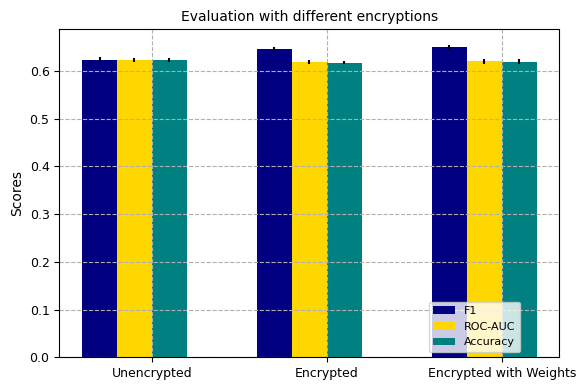

In [23]:
model_names = ['Unencrypted', 'Encrypted', 'Encrypted with Weights']
x = np.arange(len(model_names))
width = 0.2
fig, ax = plt.subplots(figsize=(6, 4))

rects1 = ax.bar(x=x - width, height=f1_, width=width, label='F1', color='navy', yerr=f1_std)
rects2 = ax.bar(x=x, height=roc_, width=width, label='ROC-AUC', color='gold', yerr=roc_std)
rects3 = ax.bar(x=x + width, height=acc_, width=width, label='Accuracy', color='teal', yerr=acc_std)

ax.set_ylabel('Scores', fontsize=10)
ax.set_title('Evaluation with different encryptions', fontsize=10)
ax.set_xticks(x + width / 2)
ax.set_xticklabels(model_names, fontsize=9)
ax.legend(loc='lower center', bbox_to_anchor=(.83, 0), fontsize=8)
ax.tick_params(axis='y', labelsize=9)
ax.grid(True, linestyle='--')
fig.tight_layout()

plt.show()


**Note:** Plots might differ slightly each run due to the noise added from encryption's precision and SGD getting stuck on local minima, which effects label assigning after decryption and horribly fails the encrypted evaluation metrics. If metrics are too much off from our example here, delete runtime and run the code again where the plot above shows the most frequent results we have observed.